In [1]:
import numpy as np
from itertools import product
from copy import deepcopy

import networkx as nx
from qiskit.circuit.classicalfunction.boolean_expression import BooleanExpression

#expression = BooleanExpression.from_dimacs_file('3sat.dimacs')

In [2]:
G0 = nx.Graph()
G0.name = 'G0'
G0.add_nodes_from([i for i in range(5)])
edge_lst = [(0, 1),
            (0, 2),
            (0, 3),
            (1, 2),
            (1, 3),
            (1, 4),
            (2, 4),
            (3, 4)]

for edge in edge_lst:
    G0.add_edge(*edge)
    
#nx.draw(G0, node_color='lightblue', 
#        with_labels=True, 
#        node_size=500)

In [3]:
G1 = nx.Graph()
G1.name = 'G1'
G1.add_nodes_from([i for i in range(7)])
edge_lst = [(0, 1),
           (0, 5),
           (0, 6),
            (1, 4),
            (1, 2),
            (2, 4),
            (2, 3),
            (3, 5),
            (4, 5),
            (5, 6)]

for edge in edge_lst:
    G1.add_edge(*edge)
    
#nx.draw(G1, node_color='lightblue', 
#        with_labels=True, 
#        node_size=500)

In [32]:
def non_adjacent_vertices(G):
    # note! this does not return any pair containing vertex 0
    lst = []
    n = int(G.number_of_nodes())
    
    for i in range(1, n-1):
        for j in range(i+1, n):
            if not G.has_edge(i, j):
                lst.append((i, j))
    return lst

non_adjacent_vertices(G0) # works!

[(2, 3)]

In [107]:
def bin_str(n):
    return bin(n).split('b')[-1]

def padded_bin_str(n, N):
    n_str = bin_str(n)
    return '0'*(N-len(n_str)) + n_str

def add1(b_str):
    return bin_str(int(b_str, 2) + 1) 

class to_dimacs:
    def __init__(self, G=None, n=None):
        if n:
            self.n = n
        elif G:
            self.n = int(G.number_of_nodes())
            self.G = G
        self.N = int(np.ceil(np.log2(self.n-1)))
    
    def index(self, i, j):
        return self.N*i + j
    
    def range_indexing(self, clause_lst):
        _clause_lst = deepcopy(clause_lst)
        for cl in range(len(clause_lst)):
            for el in range(len(clause_lst[cl])):
                i, j = clause_lst[cl][el][0]
                _clause_lst[cl][el][0] = self.index(i, j)
        return _clause_lst
    
    def step1(self):
        
        limit_str = bin_str(self.n-2)
        
        clause_lst = []
        for vertex in range(self.n-1):
            for i, bit_i in enumerate(limit_str):
                if bit_i == '1':
                    continue
                    
                negate_str = add1(limit_str[:i+1])
                clause = []
                
                for j, bit_j in enumerate(negate_str):
                    clause.append([(vertex, j), int(bit_j)])
                    
                clause_lst.append(clause)
        
        return clause_lst
    
    def equality_clause(self, vertex, l_str):
        clause = []
        for i, bit_i in enumerate(l_str):
            clause.append([(vertex, i), int(bit_i)])
        return clause
            
    def step2(self):
        clause_lst = []
        
        for vertex_i in range(self.n-1):
            for vertex_j in range(vertex_i+1, self.n-1):
                for l in range(2**self.N):
                    l_str = padded_bin_str(l, self.N)
                    c_i = self.equality_clause(vertex_i, l_str)
                    c_j = self.equality_clause(vertex_j, l_str)
                    clause_lst.append(c_i+c_j)
        return clause_lst
    
    # NOTE! Careful with G vertex indices and any other vertex indices
    # In the SAT variables, we only work with v_1, v_2, ..., v_(n-1),
    # whose indices are the same in G, but inside these function we have
    # v'_0, v'_1, ..., v'_(n-2), i.e. v'_0 = v_1
    
    def step3(self):
        clause_lst = []
        for vertex_i in range(self.n-2):
            for vertex_j in range(vertex_i+1, self.n-1):
                if self.G.has_edge(vertex_i+1, vertex_j+1):
                    continue
                    
                for l in range(1, 2**self.N-1):
                    c_l = self.equality_clause(vertex_i, padded_bin_str(l, self.N))
                    c_lm = self.equality_clause(vertex_j, padded_bin_str(l-1, self.N))
                    c_lp = self.equality_clause(vertex_j, padded_bin_str(l+1, self.N))
                    clause_lst.append(c_l+c_lm)
                    clause_lst.append(c_l+c_lp)
                    
        return clause_lst
    
    def step4(self):
        clause_lst = []
        
        for vertex_i in range(self.n-1):
            if self.G.has_edge(0, vertex_i+1):
                continue
            c0 = self.equality_clause(vertex_i, padded_bin_str(self.n-2, self.N))
            c1 = self.equality_clause(vertex_i, padded_bin_str(0, self.N))
            clause_lst.append(c0)
            clause_lst.append(c1)
        return clause_lst

In [106]:
def bool_function_generator(clause_lst):
    def f(bool_arr):
        a = True
        for clause in clause_lst:
            b = False
            for var_i, negation in clause:
                if negation == 1:
                    b = b or not bool_arr[var_i]
                else:
                    b = b or bool_arr[var_i]
            a = a and b
            #if a == False:
            #    print(clause)
            #    break
        return a
    return f

In [103]:
# test step1
# only assignments with assigned positions of 6 and 7 return false
n = 7
a = to_dimacs(n=n)
conv = 2**np.arange(a.N-1, -1, -1)
f = bool_function_generator(a.range_indexing(a.step1()))

for i in range(1000):
    bool_arr = np.random.choice([0, 1], size=(a.n-1)*a.N)
    bool_arr1 = bool_arr.reshape((n-1, a.N))
    value_arr = bool_arr1.dot(conv)
    if f(bool_arr)==0:
        assert(len(np.where(value_arr>n-2)[0]) > 0)
print('Passed')

Passed


In [104]:
# test step2
# only assignments with repeated values return false
n = 7
a = to_dimacs(n=n)

conv = 2**np.arange(a.N-1, -1, -1)
f = bool_function_generator(a.range_indexing(a.step2()))

for i in range(1000):
    bool_arr = np.random.choice([0, 1], size=(a.n-1)*a.N)
    bool_arr1 = bool_arr.reshape((n-1, a.N))
    value_arr = bool_arr1.dot(conv)
    if f(bool_arr)==0:
        assert(len(np.unique(value_arr))<len(value_arr))
                   
print('Passed')

Passed


In [100]:
# test step3
# only returns false if two non-adjacent positions have sucessive positions

G = G1
a = to_dimacs(G=G)
non_adj = non_adjacent_vertices(G)

conv = 2**np.arange(a.N-1, -1, -1)
f = bool_function_generator(a.range_indexing(a.step3()))

for i in range(1000):
    bool_arr = np.random.choice([0, 1], size=(a.n-1)*a.N)
    bool_arr1 = bool_arr.reshape((a.n-1, a.N))
    value_arr = bool_arr1.dot(conv)
    if f(bool_arr)==0:
        found = 0
        for i, j in non_adj:
            if abs(value_arr[i-1]-value_arr[j-1]) == 1:
                found = 1
                break
        assert(found==1)
                   
print('Passed')

Passed


In [137]:
# test step4
# only returns false if a vertex that is non-adjacent to v0 has position 0 or n-2

G = G1
a = to_dimacs(G=G)

conv = 2**np.arange(a.N-1, -1, -1)
f = bool_function_generator(a.range_indexing(a.step4()))

for i in range(1000):
    bool_arr = np.random.choice([0, 1], size=(a.n-1)*a.N)
    bool_arr1 = bool_arr.reshape((a.n-1, a.N))
    value_arr = bool_arr1.dot(conv)
    if f(bool_arr)==0:
        found = 0
        for vertex_i in range(a.n-1):
            if not a.G.has_edge(0, vertex_i+1) and value_arr[vertex_i] in [0, a.n-2]:
                found = 1
                break
        assert(found==1)
                   
print('Passed')

Passed


In [110]:
# test 2D index to 1D index conversion 
a = to_dimacs(n=20)
b1 = a.step1()
b2 = a.range_indexing(a.step1())


#for c1, c2 in zip(b1, b2):
#    print(c1)
#    print(c2)
#    print('')

In [138]:
# ultimate test!!! this can only print hamiltonian cycles.
G = G1
a = to_dimacs(G=G)

conv = 2**np.arange(a.N-1, -1, -1)
full_clauses = a.step1() + a.step2() + a.step3() + a.step4()
f = bool_function_generator(a.range_indexing(full_clauses))

found = 0
while found == 0:
    bool_arr = np.random.choice([0, 1], size=(a.n-1)*a.N)
    found = int(f(bool_arr))
bool_arr1 = bool_arr.reshape((a.n-1, a.N))
value_arr = bool_arr1.dot(conv)

vertices = np.arange(a.G.number_of_nodes())
print(value_arr)
print(vertices[value_arr])

[0 2 3 1 4 5]
[0 2 3 1 4 5]


In [139]:
sol = np.array([0, 2, 3, 1, 4, 5])
vertices = []
for i in range(1, a.n-1):
    vertices.append(f'v{i}')
path = []
for vertex, position in enumerate(sol):
    path.append()
    
print(vertices)

TypeError: list.append() takes exactly one argument (0 given)

In [125]:
sol

array([4, 3, 2, 5, 1, 0])

In [140]:
np.argsort(sol) + 1

array([1, 4, 2, 3, 5, 6])

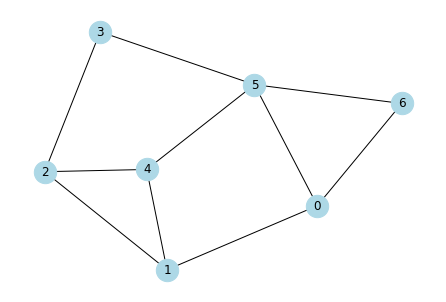

In [130]:
nx.draw(G1, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [142]:
len(full_clauses)

228

In [143]:
6*3

18

In [144]:
228/18

12.666666666666666